In [1]:
import torch

from reggae.utilities import save, load

from reggae.gp.variational.models import NonLinearLFM, ExponentialLFM
from reggae.gp.variational.trainer import TranscriptionalTrainer
from reggae.data_loaders import HafnerData
from reggae.plot.variational_plotters import Plotter
from matplotlib import pyplot as plt

import numpy as np

f64 = np.float64

torch.Size([2, 22, 13])
torch.Size([13]) 22


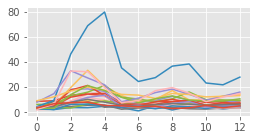

In [2]:
known_target_genes = [
    'CDKN1A', #p21
    'SESN1', #hPA26
    'DDB2',
    'TNFRSF10B',
    'BIK',
]

dataset = HafnerData('../data/', extra_targets=False)
num_replicates = 2
num_genes = len(dataset.gene_names)
num_tfs = 1
num_times = dataset[0][0].shape[0]

t_inducing = torch.linspace(0, 1, num_times, dtype=torch.float64).reshape((-1, 1))
t_observed = torch.linspace(0, 1, num_times).view(-1)
t_predict = torch.linspace(f64(0), f64(1), 80, dtype=torch.float64)

m_observed = torch.stack([
    dataset[i][1] for i in range(num_genes*2)
]).view(num_genes, num_replicates, num_times).transpose(0, 1)
print(m_observed.shape)

plt.figure(figsize=(4, 2))
for i in range(22):
    plt.plot(dataset[i][1])

print(dataset[0][1].shape, num_genes)

torch.Size([22, 13]) torch.Size([22, 13])
torch.Size([22, 13]) torch.Size([22, 13])


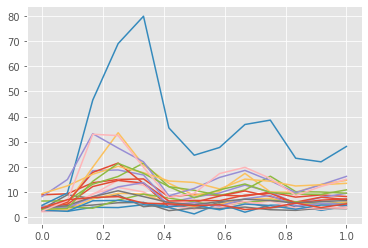

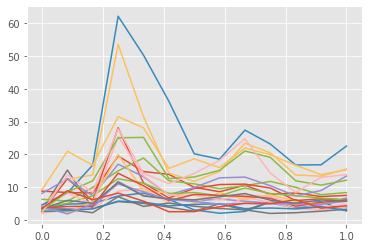

In [3]:
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset, batch_size=num_genes, shuffle=False)

for i, data in enumerate(data_loader):
    x, y = data
    print(x.shape, y.shape)
    plt.figure()
    for b in range(num_genes):
        plt.plot(x[b], y[b])

In [4]:
model = NonLinearLFM(num_genes, num_tfs, t_inducing, dataset, fixed_variance=None)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
trainer = TranscriptionalTrainer(model, optimizer, dataset)

C:\Users\Jacob\Documents\proj\reggae\reggae\gp\variational\models\model.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = Parameter(torch.tensor(t_inducing), requires_grad=learn_inducing)


### Outputs prior to training:

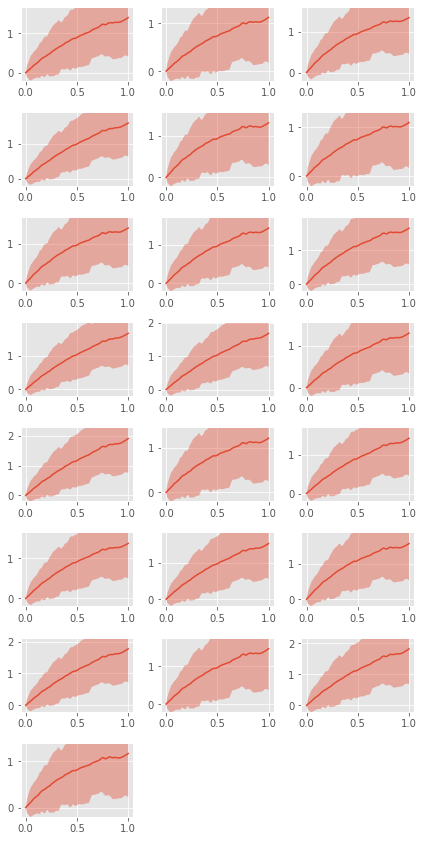

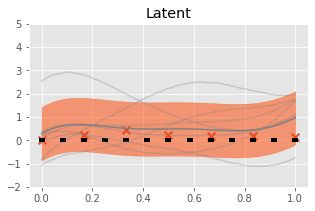

In [6]:
rtol = 1e-2
atol = rtol/10

model_kwargs = {
    'rtol': rtol, 'atol': atol
}

plotter = Plotter(model, np.array(dataset.gene_names))
plotter.plot_outputs(t_predict, t_scatter=t_observed,y_scatter=m_observed, model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-2, 5), plot_barenco=True, plot_inducing=False)

In [ ]:
tol = 1e-2
# trainer = Trainer(optimizer)
output = trainer.train(100, rtol=tol, atol=tol/10, report_interval=5, plot_interval=10)

Epoch 1/100 - Loss: 17190.69 (17190.69 0.00) λ: 0.167 b: 0.53 d 1.05 s: 2.06
Epoch 1/100 - Loss: 13773.94 (13773.94 0.00) λ: 0.139 b: 0.73 d 0.85 s: 2.26
Epoch 6/100 - Loss: 5278.81 (5149.01 129.80) λ: 0.031 b: 1.84 d 0.55 s: 3.06
Epoch 6/100 - Loss: 3963.33 (3894.22 69.11) λ: 0.025 b: 1.85 d 0.69 s: 3.00
Epoch 11/100 - Loss: 2442.18 (2417.84 24.35) λ: 0.007 b: 1.98 d 1.61 s: 2.85
Epoch 11/100 - Loss: 1929.69 (1905.49 24.20) λ: 0.006 b: 2.00 d 1.65 s: 2.90
Epoch 16/100 - Loss: 1473.23 (1449.31 23.92) λ: 0.004 b: 2.13 d 1.99 s: 3.19
Epoch 16/100 - Loss: 1306.01 (1282.28 23.73) λ: 0.004 b: 2.13 d 2.05 s: 3.17


### Outputs after training

In [ ]:
plotter.plot_losses(trainer, last_x=100)
plotter.plot_outputs(t_predict, replicate=0, t_scatter=t_observed,y_scatter=m_observed, model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-2, 7), plot_inducing=False)


In [ ]:
save(model, 'nonlinear')

In [ ]:
do_load = False
if do_load:
    model = load('nonlinear', NonLinearLFM, num_genes, num_tfs,
                 t_inducing, dataset, extra_points=2, fixed_variance=dataset.variance)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    trainer = TranscriptionalTrainer(model, optimizer, dataset)